In [ ]:
import os
import tarfile
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split  # TensorDataset
import torchvision
from torchvision.datasets import ImageFolder # MNIST, CIFAR10 etc
from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid
import torchvision.transforms as tt # ToTensor, Compose, Normalize, RandomCrop, RandomResizedCrop, RandomHorizontalFlip, RandomRotate, ColorJitter

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = device()

def todevice(data_model, device):
  if isinstance(data_model, (list, tuple)):
    return [todevice(i, device) for i in data_model]
  return data_model.to(device, non_blocking=True)

class DataDeviceLoader():
  def __init__(self, dataloader, device):
    self.dataloader = dataloader   
    self.device = device

  def __iter__(self):
    for batch in self.dataloader:
      yield todevice(batch, self.device)
  
  def __len__(self):
    return len(self.dataloader)

In [ ]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(url, '.', 'cifar10.tgz')

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

RGB_mean_std = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))             # you should calculate this for each image set, but here it is just given
train_normalized = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                              #  tt.RandomResizeCrop(256, scale=(0.5, 0.9), ratio=(1, 1)),
                               tt.RandomHorizontalFlip(),
                              #  tt.RandomRotate(),
                              #  tt.CollorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                               tt.ToTensor(),
                               tt.Normalize(*RGB_mean_std, inplace=True)])
valid_normalized = tt.Compose([tt.ToTensor(), tt.Normalize(*RGB_mean_std)])

dir = './data/cifar10'
traindataset = ImageFolder(dir + '/train', train_normalized)          # instead transform=ToTensor() we used train_normalized
testset = ImageFolder(dir + '/test', valid_normalized)                #!!! we can decide to use test set as valid set, so that we have more data for training

# torch.manual_seed(42)
# fraction = 1/20
# valid = int(len(traindataset) * fraction)
# train = len(traindataset) - valid
# trainset, validset = random_split(traindataset, [train, valid])

batchsize = 128
trainloader = DataLoader(traindataset, batch_size=batchsize, shuffle=True, num_workers=2, pin_memory=True)  # traindataset directly instead of trainset
# validloader = DataLoader(validset, batch_size=batchsize*2, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=batchsize*2, num_workers=2, pin_memory=True)

trainload = DataDeviceLoader(trainloader, device)
# validload = DataDeviceLoader(validloader, device)
testload = DataDeviceLoader(testloader, device) 

Using downloaded and verified file: ./cifar10.tgz


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


in './data/cifar10' folder there are two folders ['train', 'test']
in 'train' folder there are following folders ['bird', 'truck', 'frog', 'dog', 'automobile', 'horse', 'airplane', 'ship', 'deer', 'cat']
in folder 'dog' there are 5000 images
shape of each image is torch.Size([3, 32, 32])


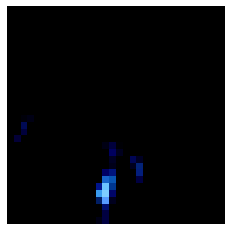

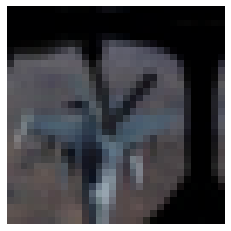

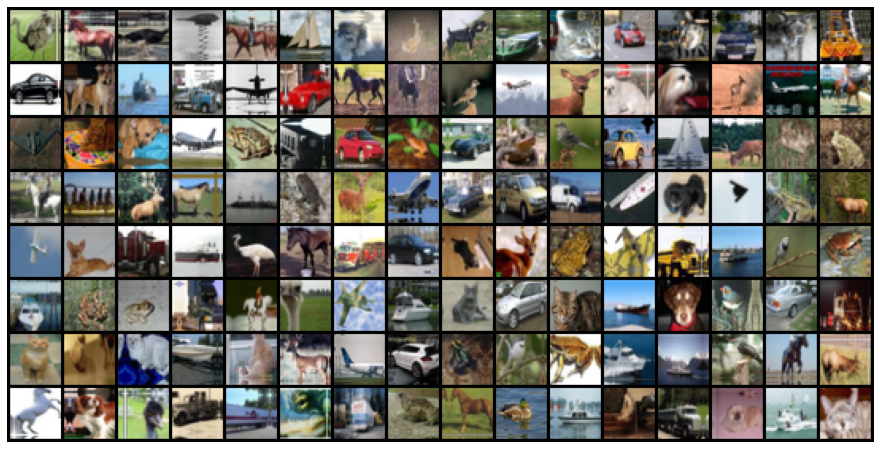

In [ ]:
print(f"in './data/cifar10' folder there are two folders {os.listdir(dir)}")
print(f"in 'train' folder there are following folders {os.listdir(dir + '/train')}")
print(f"in folder 'dog' there are {len(os.listdir(dir + '/train/dog'))} images")

image10, _ = traindataset[10]
print(f"shape of each image is {image10.shape}")

def unnormalize(images, means, standarddeviations):
  means = torch.tensor(means).reshape(1, 3, 1, 1)  # starting shape was one raw 3 columns (1, 3) and we added those dimensions as images have those dimensions
  stds = torch.tensor(standarddeviations).reshape(1, 3, 1, 1)
  return stds * images + means                   # this is reversed what tt.Normalize does: (images - means) / stds 
                                                 # and I do not know why stds * images + means works better instead of stds * (images + means)
plt.figure(figsize=(4, 4))
plt.imshow(image10.permute((1, 2, 0)))           # here permute uses two (()) below with make_grid it uses only one ()
plt.axis('off')

plt.figure(figsize=(4, 4))
plt.imshow(unnormalize(image10, *RGB_mean_std).reshape(3, 32, 32).permute((1, 2, 0)).clamp(0,1))
plt.axis('off') 

for images, lables in trainloader:
  plt.figure(figsize=(16, 8))
  images = unnormalize(images, *RGB_mean_std)
  plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0, 1))           # clamp(0, 1) brings pixels to range between 0 and 1 if some are not
  plt.axis('off')
  break 

In [ ]:
class LossPart(nn.Module):
  def trainloss(self, batch):
    images, lables = batch
    out = self(images)
    loss = F.cross_entropy(out, lables)
    return loss

  def validloss(self, batch):
    images, lables = batch
    out = self(images)
    loss = F.cross_entropy(out, lables)
    _, bestpredictions = torch.max(out, dim=1)
    accuracy = torch.tensor(torch.sum(bestpredictions==lables).item() / len(bestpredictions))
    return {'accuracy': accuracy, 'loss': loss.detach()}

  def epochend(self, epochoutputs):
    epochlosses = [batch['loss'] for batch in epochoutputs]
    epochaverageloss = torch.stack(epochlosses).mean()
    epochaccuracies = [batch['accuracy'] for batch in epochoutputs]
    epochaverageaccuracy = torch.stack(epochaccuracies).mean()
    return {'epochloss' : epochaverageloss.item(), 'epochaccuracy' : epochaverageaccuracy.item()}

def convblock(input_channels, output_channels, pool=False):
  layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ForwardPart(LossPart):                                                    # resnet9 architecture
  def __init__(self, input_channels, output_classes):
    super().__init__()

    self.conv1 = convblock(input_channels, 64)
    self.conv2 = convblock(64, 128, pool=True)                                  # here image size became 16X16
    self.res1 = nn.Sequential(convblock(128, 128), convblock(128, 128))

    self.conv3 = convblock(128, 256)
    self.conv4 = convblock(256, 512, pool=True)                                 # here image size became 8X8
    self.res2 = nn.Sequential(convblock(512, 512), convblock(512, 512))

    self.classify = nn.Sequential(nn.MaxPool2d(4),                              # here image size became 2X2
                                  nn.Flatten(),
                                  nn.Dropout(0.2),
                                  nn.Linear(512*2*2, output_classes))
  def forward(self, xbatch):
    out = self.conv1(xbatch)
    out = self.conv2(out)
    out = self.res1(out) + out                                                  # residual is addition of 'out' from previous layers!!!
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classify(out)
    return out

model = todevice(ForwardPart(3, 10), device)
model

In [ ]:
@torch.no_grad()
def evaluate(model, valid_or_testload):
  model.eval()
  epochoutputs = [model.validloss(batch) for batch in valid_or_testload]
  epochresult = model.epochend(epochoutputs)
  return epochresult

def fit(model, trainload, testload, max_lr, epochs, weight_decay=0, clip_grad=None, optim=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []
  optimizer = optim(model.parameters(), max_lr, weight_decay=weight_decay)
  scedule = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(trainload))
  
  for epoch in range(epochs):
    model.train()
    learning_rates = []
    training_losses = []

    for batch in trainload:
      loss = model.trainloss(batch)
      training_losses.append(loss)
      loss.backward()
      if clip_grad:
        nn.utils.clip_grad_value_(model.parameters(), clip_grad)
      optimizer.step()                                                          # here will be used weight_decay=weight_decay
      optimizer.zero_grad()
      learning_rates.append([i['lr'] for i in optimizer.param_groups])
      scedule.step()

    epochresult = evaluate(model, testload)
    epochresult['epoch_trainloss'] = torch.stack(training_losses).mean().item() # creates new key-value pair in dictionary
    epochresult['lr'] = learning_rates                                          
    history.append(epochresult)
  
  return history

In [ ]:
max_lr = 0.01
epochs = 8
weight_decay = 1e-4
clip_grad = 0.1
optim = torch.optim.Adam

training = []

%time
training += fit(model, trainload, testload, max_lr, epochs, weight_decay, clip_grad, optim)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.39 µs


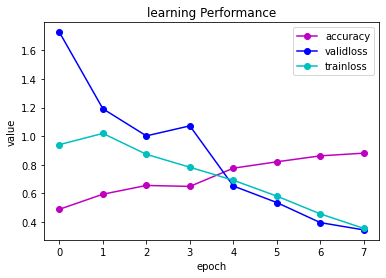

In [ ]:
accuracies = [acc['epochaccuracy'] for acc in training]
validlosses = [loss['epochloss'] for loss in training]
trainlosses = [loss.get('epoch_trainloss') for loss in training]
learningrates = np.concatenate([lr.get('lr', []) for lr in training])
plt.plot(accuracies, '-mo')
plt.plot(validlosses, '-bo')
plt.plot(trainlosses, '-co')
# plt. plot(learningrates, '-yo')                       #plot separately as scale is completely different and nothing will be seen in same graph, xlabel=batch
plt.legend(['accuracy', 'validloss', 'trainloss', 'lrs'])
plt.xlabel('epoch')
plt.ylabel('value')
plt.title('learning Performance');

lable is automobile, predicted was automobile


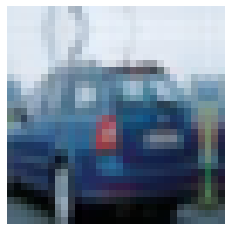

In [ ]:
# We do not do testing as we used testset for validation and do not have left data for testing
def predict(model, image):
  uimage = todevice(image.unsqueeze(0), device)
  mimage = model(uimage)
  _, bestprediction = torch.max(mimage, dim=1)
  return bestprediction[0].item()

image, label = traindataset[7000]
predicted = predict(model, image)
img = unnormalize(image, *RGB_mean_std).reshape(3, 32, 32)
print(f"lable is {traindataset.classes[label]}, predicted was {traindataset.classes[predicted]}")
plt.imshow(img.permute((1, 2, 0)).clamp(0, 1))
plt.axis('off');

In [ ]:
torch.save(model.state_dict(), 'cifar10_resnet9.pth')
new_model = ForwardPart(3, 10)
new_model.load_state_dict(torch.load('cifar10_resnet9.pth'))